In [1]:
%matplotlib inline

from __future__ import division
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt

from matplotlib import rc
rc('savefig', dpi=100)

from pyhsmm.util.text import progprint_xrange
from pyhsmm.util.stats import whiten, diag_whiten

import flyball.load as load

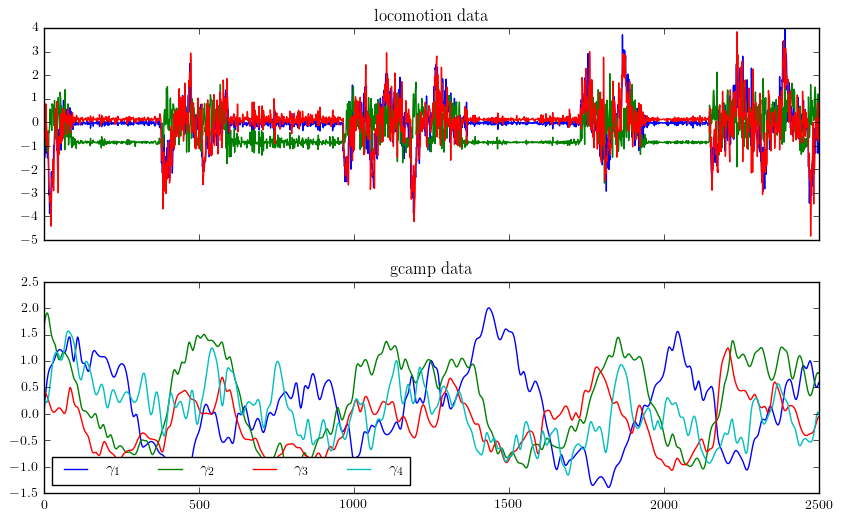

In [2]:
reload(load)

data = diag_whiten(load.load())
gcamp_data, locomotion_data = load.split_data(data)

load.plot_data(data[:2500])

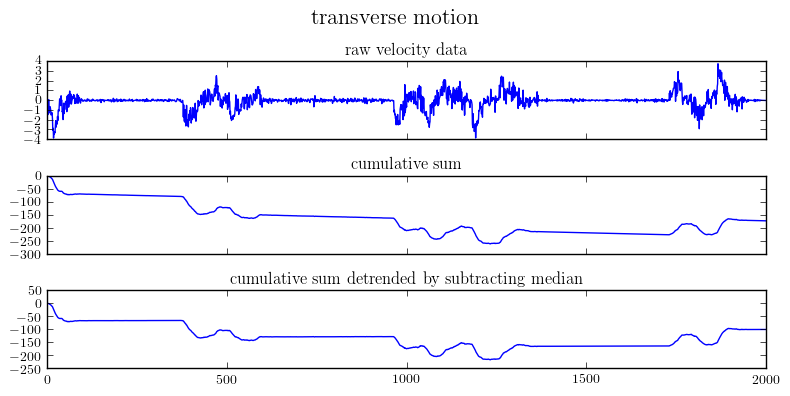

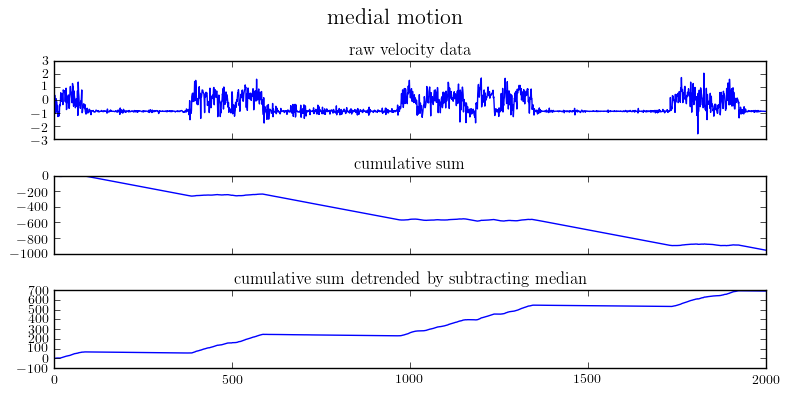

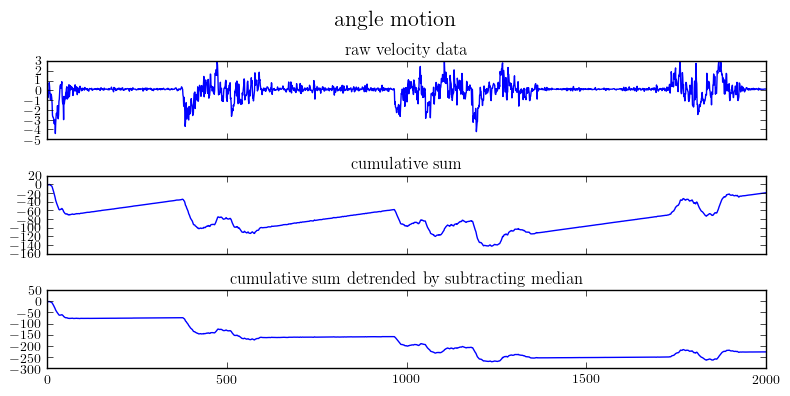

In [3]:
def plot_cumsum(data, title=''):
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(8, 4))
    fig.suptitle(title, fontsize=16)
    
    ax1.plot(data)
    ax1.set_title('raw velocity data')
    
    ax2.plot(np.cumsum(data, axis=0))
    ax2.set_title('cumulative sum')
    
    ax3.plot(np.cumsum(data - np.median(data), axis=0))
    ax3.set_title('cumulative sum detrended by subtracting median')
    
    fig.tight_layout()
    fig.subplots_adjust(top=0.85)
    
def plot_cumsums(data):
    plot_cumsum(data[:,0], 'transverse motion')
    plot_cumsum(data[:,1], 'medial motion')
    plot_cumsum(data[:,2], 'angle motion')
    
plot_cumsums(locomotion_data[:2000])

In [4]:
def detrend_fixed(data):
    return data - np.median(data, axis=0)

from scipy.signal import medfilt
def detrend_sliding(data, half_window=250):
    return (data - medfilt(data, [2*half_window+1, 1]))[half_window:-half_window]

cdata = np.cumsum(detrend_sliding(locomotion_data[:10000]), axis=0)

In [5]:
from moviepy.video.io.bindings import mplfig_to_npimage
from moviepy.editor import VideoClip

def make_movie(data, arrow_size=1.):
    fig, ax = plt.subplots(figsize=(6, 6))
    
    arrows = []
    def plot_frame(x, y, theta):
        if arrows:
            arrows.pop().remove()
        arrows.append(ax.arrow(
            x, y, arrow_size*np.cos(theta), arrow_size*np.sin(theta),
                head_width=0.5*arrow_size, head_length=0.5*arrow_size))

    def make_clip(start, stop, fps):
        sl = slice(start, stop)
        
        # set up data cumsum
        xs, ys, thetas = np.cumsum(detrend_fixed(data[start:stop]), axis=0).T
        # xs, ys, thetas = cdata.T  # TODO roll in sliding detrended data
        thetas = np.deg2rad(thetas + 180.)
        
        # set up plot axis limits
        ax.set_xlim(xs[sl].min()-2*arrow_size, xs[sl].max()+2*arrow_size)
        ax.set_ylim(ys[sl].min()-2*arrow_size, ys[sl].max()+2*arrow_size)
        ax.axis('off')
        
        # write frame-making function
        # NOTE: assumes make_frame callback is called in order; not sure if that's guaranteed by moviepy
        frames = iter(plot_frame(x, y, theta) for x, y, theta in zip(xs, ys, thetas))
        def make_frame_mpl(t):
            next(frames)
            return mplfig_to_npimage(fig)
        
        # plot static figure for reference
        plot_cumsums(data[sl])
        
        # generate movie
        dur = (stop-start) / fps
        anim = VideoClip(make_frame_mpl, duration=dur).ipython_display(fps=fps)
        plt.close(fig.number)
        return anim

    return make_clip

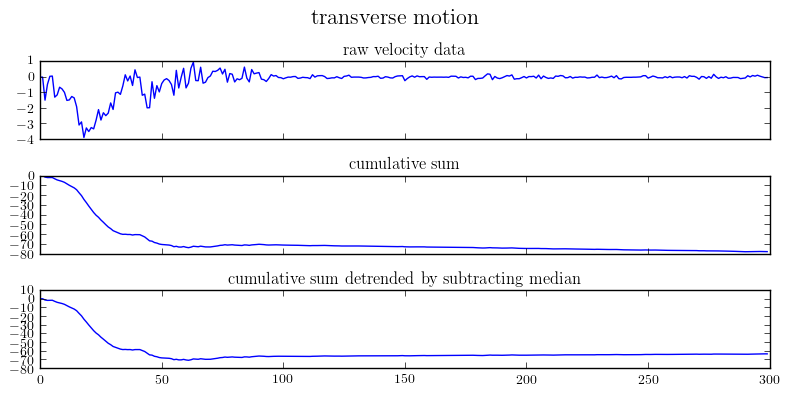

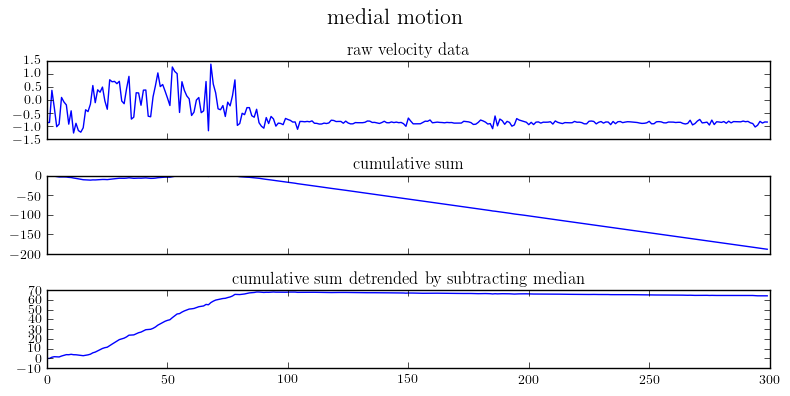

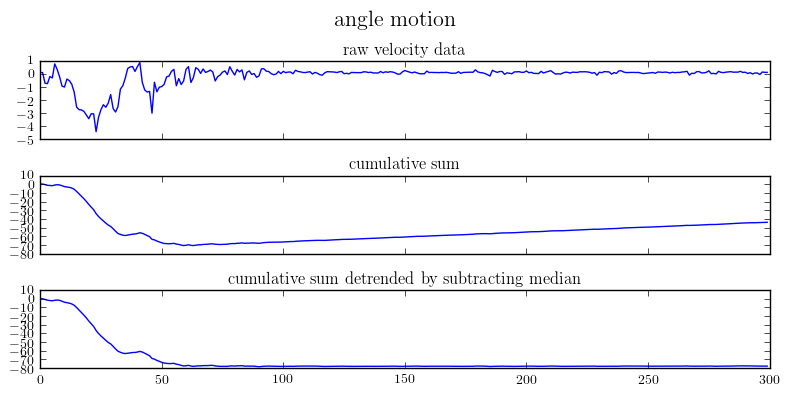

In [6]:
make_movie(locomotion_data, arrow_size=2.)(start=0, stop=300, fps=20)